# Severity prediction of traffic accident in the City of Seattle 

This project aimed at predicting collision severity based on a dataset hosted by the City of Seattle. In particular, the collisions with only property damage are labeled as less severe accidents; the ones involving injuries are deemed as severe. The dataset consists of features such as environmental conditions (<em>e.g.</em>, weather, road condition, and lighting condition), time of the accident, location information (<em>e.g.</em>, type of road), as well as the number of people and vehicles involved. Some of these factors, such as the number of cyclists in the recorded accidents, tend to be obvious features in predicting the severity of the collision, whereas some may be inevident (<em>e.g.</em>, particular road region) but bearing important insights into mitigating the severity of traffic accidents for the city.  

---
## Data
* Categorical features

## Model

## Highlights
* what lead to severe collision

### Load libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, r2_score, confusion_matrix, classification_report, roc_curve, roc_auc_score

import xgboost as xgb

from catboost import CatBoostClassifier, Pool
import shap

from matplotlib import pyplot as plt
import seaborn as sns

In [9]:
pd.set_option('display.max_columns', None)

### Read and explore the dataset

In [2]:
df = pd.read_csv('Data-Collisions.csv', low_memory=False, parse_dates=["INCDATE"])
df["MONTH"] = df["INCDATE"].dt.month
df["YEAR"] = df["INCDATE"].dt.year

print(df.shape)
df.head()

(194673, 40)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,NaN,NaN,NaN,10,Entering at angle,0,0,N,3,2013
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N,12,2006
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N,11,2004
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,NaN,NaN,NaN,23,From same direction - all others,0,0,N,3,2013
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,NaN,4028032.0,NaN,10,Entering at angle,0,0,N,1,2004


In [3]:
df.columns
# 'STATUS'??

Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR', 'MONTH', 'YEAR'],
      dtype='object')

1    70.109877
2    29.890123
Name: SEVERITYCODE, dtype: float64


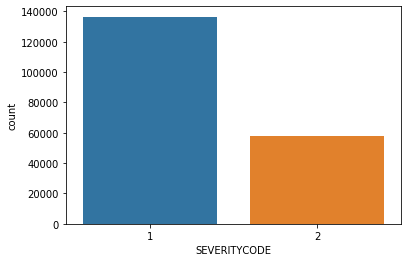

In [4]:
sns.countplot(df["SEVERITYCODE"])

print(df["SEVERITYCODE"].value_counts(normalize=True)*100)

In [22]:
# data type and cardinality for each feature
col_names = []
col_cardinality = []

for feature in df.columns:
    col_names.append(feature)
    cardinality = len(df[feature].unique())
    col_cardinality.append(cardinality)

pd.DataFrame([col_cardinality], columns=col_names)

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,MONTH,YEAR
0,2,23564,23840,194673,194673,194673,194670,2,4,7615,24103,3,2,2,2,11,47,7,3,13,5985,162058,8,39,39,2,2,12,10,10,2,114933,2,64,63,1955,2198,2,12,17


### Summary of features
#### Location related information
X, Y(~24000): continous; INTKEY(7615); LOCATION(24103); ADDRTYPE(4); JUNCTIONTYPE(8)

#### Time of the collision
INCDATE[month, year], INCDTTM

#### Descriptive type of the collision
COLLISIONTYPE(11), PERSONCOUNT, PEDCOUNT, PEDCYLCOUNT, VEHCOUNT, 

SDOT_COLCODE(39); SDOT_COLDESC [code given to the collision by SDOT]; ST_COLCODE(64); ST_COLDESC [State Collision Code];

SEGLANEKEY(1955); CROSSWALKKEY(2198)

HITPARKEDCAR(2)

#### Possible reasons for collison
INATTENTIONIND(2); UNDERINFL(2); SPEEDING(2); 

PEDROWNOTGRNT(2) [Whether or not the pedestrian right of way was not granted]

#### Other related conditions of the collision
WEATHER(12); ROADCOND(10); LIGHTCOND(10)

#### unknown...
STATUS (matched, unmatched)

### Distribution of severity among cardinality for each feature

In [52]:
feature = 'COLLISIONTYPE'
df[[feature, "SEVERITYCODE"]].groupby([feature, "SEVERITYCODE"]).size()

# df.groupby(by=feature).size()  #if only interested in how feature is distributed

COLLISIONTYPE  SEVERITYCODE
Angles         1               21050
               2               13624
Cycles         1                 671
               2                4744
Head On        1                1152
               2                 872
Left Turn      1                8292
               2                5411
Other          1               17591
               2                6112
Parked Car     1               45325
               2                2662
Pedestrian     1                 672
               2                5936
Rear Ended     1               19419
               2               14671
Right Turn     1                2347
               2                 609
Sideswipe      1               16103
               2                2506
dtype: int64

In [53]:
df['COLLISIONTYPE'].unique()

array(['Angles', 'Sideswipe', 'Parked Car', 'Other', 'Cycles',
       'Rear Ended', 'Head On', nan, 'Left Turn', 'Pedestrian',
       'Right Turn'], dtype=object)

In [17]:
df['PEDROWNOTGRNT'].describe()

count     4667
unique       1
top          Y
freq      4667
Name: PEDROWNOTGRNT, dtype: object

#### Locations

(-122.39972081136344,
 -122.27004288863661,
 47.5025454816358,
 47.731724108364205)

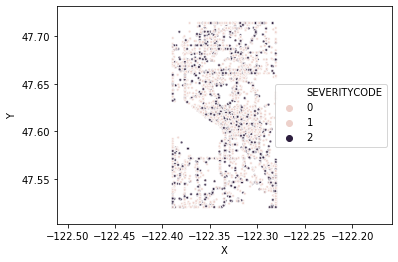

In [148]:
# plot the X/Y coordinates as a scatterplot where each dot is color-coded by the severity code.
# we randomly sample N (e.g. N=5000) to prevent from cluttering.
# X/Y values are clamped so that they are not affected by outliers

indices = np.arange(df.shape[0])
np.random.shuffle(indices)

g = sns.scatterplot(data=df.loc[indices[:5000], :], x='X', y='Y', hue='SEVERITYCODE', alpha=.8, s=8)

# df['Y'].quantile([.05, .95])  # the range of X,Y coordinates for location
g.set(xlim=df['X'].quantile([.05, .95]), ylim=df['Y'].quantile([.05, .95]))
plt.axis('equal')

In [3]:
# we can also plot the likelihood of severity on one axis at a time, at a coarser granularity

def binify_values(s, clamp_alpha=.05, bins=50):
    low, hi = s.quantile([clamp_alpha, 1.0 - clamp_alpha])
    s[s < low] = low
    s[s > hi] = hi
    
    return pd.cut(s, bins, labels=np.arange(bins))

In [4]:
def compute_severity_ratio(g):
    severity_counts = g.groupby('SEVERITYCODE').size()
    ratio = severity_counts.iloc[0] / severity_counts.iloc[1]
    return ratio


def severity_location_distribution(df, loc, nbin):
    
    # dataframe with binned loc and severity within that range
    df_loc = pd.DataFrame({loc: binify_values(df[loc], bins=nbin), 'SEVERITYCODE': df['SEVERITYCODE']})
    
    # count each severity level
    loc_by_severity_counts = df_loc.groupby([loc, 'SEVERITYCODE']).size().reset_index().rename(columns={0: 'count'})
    
    # visualize
    sns.barplot(data=loc_by_severity_counts, x=loc, y='count', hue='SEVERITYCODE')
#     df_loc.groupby(loc).apply(compute_severity_ratio).plot()


/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/i

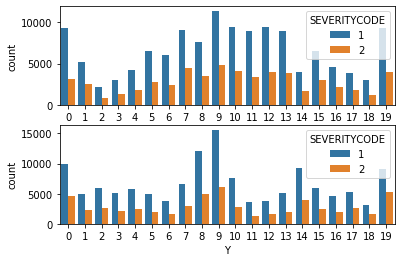

In [26]:
plt.subplot(2, 1, 1)
severity_location_distribution(df, 'X', nbin=20)

plt.subplot(2, 1, 2)
severity_location_distribution(df, 'Y', nbin=20)


#### Time of the day
For example, distribution of collision severity by month & time of the day

In [233]:
df['INCDTTM'] #'INCDTTM', 'INCDATE'

0           3/27/2013 2:54:00 PM
1          12/20/2006 6:55:00 PM
2         11/18/2004 10:20:00 AM
3           3/29/2013 9:26:00 AM
4           1/28/2004 8:04:00 AM
                   ...          
194668     11/12/2018 8:12:00 AM
194669     12/18/2018 9:14:00 AM
194670      1/19/2019 9:25:00 AM
194671      1/15/2019 4:48:00 PM
194672     11/30/2018 3:45:00 PM
Name: INCDTTM, Length: 194673, dtype: object

In [53]:
np.sum(df['MONTH'].isnull())

0

In [26]:
# 
df['X'].describe()

count    189339.000000
mean       -122.330518
std           0.029976
min        -122.419091
25%        -122.348673
50%        -122.330224
75%        -122.311937
max        -122.238949
Name: X, dtype: float64

### Data preprocess 

#### Data clean up
(fillna & missing data, combine same meaning labels)
* UNDERINFL

In [5]:
# e.g., UNDERINFL, four categories, however, [0,1] & [N,Y] indicate likewise
def for_UNDERINFL(x):
    if x in ['Y','1']:
        return 1
    elif x in ['N','0']:
        return 0
    else:
        return x
    
df["UNDERINFL"] = df["UNDERINFL"].apply(for_UNDERINFL)

In [6]:
df['UNDERINFL'].fillna(0, inplace=True)

* location X, Y

In [7]:
# location
loc_y = binify_values(df['Y'], bins=50)
loc_y = loc_y.cat.add_categories(-99)  # fill missing data with -99
loc_y.fillna(-99, inplace=True)
loc_x = binify_values(df['X'], bins=50)
loc_x = loc_x.cat.add_categories(-99)  # fill missing data with -99
loc_x.fillna(-99, inplace=True)

/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/chengqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Ordinal encoding of categorical features

In [189]:
def categ_to_ordinal(df, feature='COLLISIONTYPE'):
    enc = preprocessing.OrdinalEncoder(dtype=np.int)
    col = df[feature].fillna('').values.reshape(-1, 1)
    ordinal_encoded = enc.fit_transform(col)

    return pd.Series(ordinal_encoded.reshape(-1), name=feature)

In [190]:
categ_to_ordinal(df)

0          1
1         10
2          6
3          5
4          1
          ..
194668     3
194669     8
194670     4
194671     2
194672     8
Name: COLLISIONTYPE, Length: 194673, dtype: int64

#### One hot encoding of categorical features

In [8]:
def categ_to_one_hot(df, feature='ROADCOND'):
    enc = preprocessing.OneHotEncoder()
    # fill in None, to reshape to 2D (column)
    col = df[feature].fillna("").values.reshape(-1, 1)
    # one hot encode
    one_hot_encoded = enc.fit_transform(col).toarray()
    
    # to a data frame
    df_cols = {}
    for col_index, cat in enumerate(enc.categories_[0]):
        df_cols[feature + '_' + cat] = one_hot_encoded[:, col_index]

    return pd.DataFrame(df_cols)

In [208]:
df_addrtype = categ_to_one_hot(df, feature='ADDRTYPE')
df_collisiontype = categ_to_one_hot(df, feature='COLLISIONTYPE')
df_junctiontype = categ_to_one_hot(df, feature='JUNCTIONTYPE')

df_weather = categ_to_one_hot(df, feature='WEATHER')
df_roadcond = categ_to_one_hot(df, feature='ROADCOND')
df_lightcond = categ_to_one_hot(df, feature='LIGHTCOND')

In [35]:
df['WEATHER'].unique()

array(['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [209]:
df_sdotcold=categ_to_one_hot(df, feature='SDOT_COLDESC')

### Decision tree model

In [210]:
df_preprocessed = pd.concat([df_addrtype, df_collisiontype, df_junctiontype, 
                             df_weather, df_roadcond, df_lightcond, 
                             df_sdotcold,
                             df[['PERSONCOUNT', 'PEDCYLCOUNT', 'PEDCOUNT','VEHCOUNT','UNDERINFL']], 
                             loc_y.astype(int), loc_x.astype(int)], axis=1)
# df_preprocessed = pd.concat([df['PEDCOUNT'], df['PEDCYLCOUNT'], df['VEHCOUNT'], df_sdotcold], axis=1)
# df_preprocessed = pd.concat([df_collisiontype, df['UNDERINFL']], axis=1)
df_preprocessed

,ADDRTYPE_,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,COLLISIONTYPE_,COLLISIONTYPE_Angles,COLLISIONTYPE_Cycles,COLLISIONTYPE_Head On,COLLISIONTYPE_Left Turn,COLLISIONTYPE_Other,...,SDOT_COLDESC_PEDALCYCLIST STRUCK PEDALCYCLIST FRONT END AT ANGLE,SDOT_COLDESC_PEDALCYCLIST STRUCK PEDALCYCLIST REAR END,SDOT_COLDESC_PEDALCYCLIST STRUCK PEDESTRIAN,PERSONCOUNT,PEDCYLCOUNT,PEDCOUNT,VEHCOUNT,UNDERINFL,Y,X
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,0,0,2,0.0,46,28
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,0,0,2,0.0,31,17
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4,0,0,3,0.0,21,23
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,3,0,0,3,0.0,20,23
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,0,0,2,0.0,4,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,3,0,0,2,0.0,10,44
194669,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,0,0,2,0.0,43,18
194670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,3,0,0,2,0.0,41,36
194671,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2,1,0,1,0.0,40,13


In [146]:
# clf = DecisionTreeClassifier(random_state=0)
# cross_val_score(clf, df_preprocessed, df['SEVERITYCODE'], cv=10)
#
#
# df_collisiontype by itself can push the cross_val_score to ~.75;
# df['PEDCYLCOUNT'] can do ~.72; df['PEDCOUNT'] is ~.73; df['VEHCOUNT'] is ~.71; these three combined reaches .75;
#

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed, df['SEVERITYCODE'], test_size=0.2, random_state=1)
tree = DecisionTreeClassifier(criterion="gini", max_depth = None, class_weight=None).fit(X_train, y_train)
# class_weight:default-None; 'balanced' means to adjust weights based on label distribution 
# (inverse to the proportion, so more leads to less important)

tree_pred = tree.predict(X_test)
tree_pred

print('Score:',accuracy_score(tree_pred, y_test))
print('F1-Score:',f1_score(tree_pred, y_test))
print('Confusion Martix:')
print(confusion_matrix(y_test, tree_pred))
print('')
print('Classification Report:')
print(classification_report(y_test, tree_pred))

Score: 0.6973930910491846
F1-Score: 0.7889362616889399
Confusion Martix:
[[22020  5339]
 [ 6443  5133]]

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.80      0.79     27359
           2       0.49      0.44      0.47     11576

    accuracy                           0.70     38935
   macro avg       0.63      0.62      0.63     38935
weighted avg       0.69      0.70      0.69     38935



0.6516689956063727


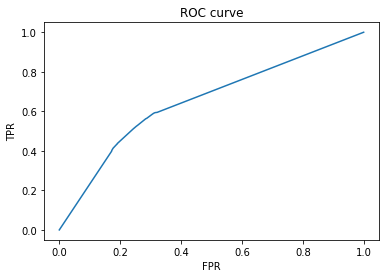

In [58]:
predictions = tree.predict_proba(X_test)
print(roc_auc_score(y_test, predictions[:,1]))

fpr, tpr, _ = roc_curve(y_test-1, predictions[:,1])
# fpr_0, tpr_0, _ = roc_curve((3-y_test)-1, predictions[:,0])


plt.clf()
plt.plot(fpr, tpr)
# plt.plot(fpr_0, tpr_0)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [100]:
y_test

94063     1
137563    2
78237     1
105763    1
138711    1
         ..
150024    1
182941    2
43164     1
132107    2
123955    2
Name: SEVERITYCODE, Length: 38935, dtype: int64

In [59]:
pd.Series(tree.feature_importances_, index=df_preprocessed.columns)
# the importance decided based on the information gain achieved based on the feature at splits
#

ADDRTYPE_                0.000355
ADDRTYPE_Alley           0.000161
ADDRTYPE_Block           0.005232
ADDRTYPE_Intersection    0.004998
COLLISIONTYPE_           0.002613
                           ...   
PEDCOUNT                 0.060699
VEHCOUNT                 0.013039
UNDERINFL                0.008151
Y                        0.187358
X                        0.194240
Length: 101, dtype: float64

In [16]:
tree.tree_.max_depth

30

### Random forest

In [60]:
forest = RandomForestClassifier(n_estimators=100,criterion="gini", max_depth = 5, 
                                class_weight=None).fit(X_train, y_train)
# max_features: default - 'auto', sqrt(n_features)
# bootstrap: bool, default=True
# max_samples: int or float, default=None (when bootstrap is TRUE, None - draw same number of samples)
#
forest_pred = forest.predict(X_test)
forest_pred

print('Score:',accuracy_score(forest_pred, y_test))
print('F1-Score:',f1_score(forest_pred, y_test))
print('Confusion Martix:')
print(confusion_matrix(y_test, forest_pred))
print('')
print('Classification Report:')
print(classification_report(y_test, forest_pred))

predictions = forest.predict_proba(X_test)
print('auc: ' + str(roc_auc_score(y_test, predictions[:,1])))


Score: 0.7502761011942982
F1-Score: 0.847895123820847
Confusion Martix:
[[27100   259]
 [ 9464  2112]]

Classification Report:
              precision    recall  f1-score   support

           1       0.74      0.99      0.85     27359
           2       0.89      0.18      0.30     11576

    accuracy                           0.75     38935
   macro avg       0.82      0.59      0.58     38935
weighted avg       0.79      0.75      0.69     38935

auc: 0.7841056647347828


In [61]:
pd.Series(forest.feature_importances_, index=df_preprocessed.columns)

ADDRTYPE_                0.000373
ADDRTYPE_Alley           0.000144
ADDRTYPE_Block           0.030700
ADDRTYPE_Intersection    0.033054
COLLISIONTYPE_           0.000409
                           ...   
PEDCOUNT                 0.089248
VEHCOUNT                 0.034384
UNDERINFL                0.001437
Y                        0.001276
X                        0.001429
Length: 101, dtype: float64

In [62]:
forest.n_features_

101

### xgboost

In [223]:
dtrain = xgb.DMatrix(X_train, label=y_train-1)
dtest = xgb.DMatrix(X_test, label=y_test-1)

param = {'max_depth': 5, 'eta': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 50
bst = xgb.train(param, dtrain, num_round, evallist, 
                early_stopping_rounds=5) # if the metric result do not improve for N rounds, model should stop training


[0]	validation_0-auc:0.78698	validation_0-logloss:0.60130	validation_1-auc:0.78575	validation_1-logloss:0.60158
[1]	validation_0-auc:0.79190	validation_0-logloss:0.55098	validation_1-auc:0.79012	validation_1-logloss:0.55157
[2]	validation_0-auc:0.79351	validation_0-logloss:0.52158	validation_1-auc:0.79185	validation_1-logloss:0.52231
[3]	validation_0-auc:0.79500	validation_0-logloss:0.50344	validation_1-auc:0.79288	validation_1-logloss:0.50435
[4]	validation_0-auc:0.79630	validation_0-logloss:0.49255	validation_1-auc:0.79391	validation_1-logloss:0.49367
[5]	validation_0-auc:0.79709	validation_0-logloss:0.48509	validation_1-auc:0.79465	validation_1-logloss:0.48643
[6]	validation_0-auc:0.79797	validation_0-logloss:0.48064	validation_1-auc:0.79515	validation_1-logloss:0.48209
[7]	validation_0-auc:0.80022	validation_0-logloss:0.47765	validation_1-auc:0.79656	validation_1-logloss:0.47947
[8]	validation_0-auc:0.80100	validation_0-logloss:0.47436	validation_1-auc:0.79719	validation_1-logloss:

[73]	validation_0-auc:0.82404	validation_0-logloss:0.44840	validation_1-auc:0.80206	validation_1-logloss:0.46790
[74]	validation_0-auc:0.82427	validation_0-logloss:0.44816	validation_1-auc:0.80218	validation_1-logloss:0.46780
[75]	validation_0-auc:0.82443	validation_0-logloss:0.44803	validation_1-auc:0.80217	validation_1-logloss:0.46781
[76]	validation_0-auc:0.82474	validation_0-logloss:0.44777	validation_1-auc:0.80219	validation_1-logloss:0.46779
[77]	validation_0-auc:0.82483	validation_0-logloss:0.44769	validation_1-auc:0.80210	validation_1-logloss:0.46784
[78]	validation_0-auc:0.82508	validation_0-logloss:0.44750	validation_1-auc:0.80205	validation_1-logloss:0.46787
[79]	validation_0-auc:0.82537	validation_0-logloss:0.44727	validation_1-auc:0.80196	validation_1-logloss:0.46795
[80]	validation_0-auc:0.82569	validation_0-logloss:0.44700	validation_1-auc:0.80188	validation_1-logloss:0.46804
[81]	validation_0-auc:0.82609	validation_0-logloss:0.44669	validation_1-auc:0.80175	validation_1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [214]:
ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
print('auc: ' + str(roc_auc_score(y_test-1, ypred)))

auc: 0.7961123952040282


In [73]:
# xgb.plot_importance(bst)

In [74]:
# bst.get_fscore()
bst_importance = bst.get_score(importance_type='gain')
{k: v for k, v in sorted(bst_importance.items(), key=lambda item: item[1], reverse=True)}

{'PEDCYLCOUNT': 2424.9231187,
 'PEDCOUNT': 1643.124504185,
 'COLLISIONTYPE_Parked Car': 1332.8551600100002,
 'COLLISIONTYPE_Sideswipe': 630.014629384,
 'COLLISIONTYPE_': 391.621338,
 'COLLISIONTYPE_Right Turn': 378.64679,
 'SDOT_COLDESC_MOTOR VEHICLE OVERTURNED IN ROAD': 242.55426136,
 'PERSONCOUNT': 114.76855991664706,
 'COLLISIONTYPE_Other': 114.06987076333336,
 'ROADCOND_Unknown': 104.44279981833336,
 'SDOT_COLDESC_NOT ENOUGH INFORMATION / NOT APPLICABLE': 87.43925870999999,
 'SDOT_COLDESC_MOTOR VEHCILE STRUCK PEDESTRIAN': 83.74333185,
 'SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE': 75.23205573,
 'COLLISIONTYPE_Cycles': 62.812645,
 'JUNCTIONTYPE_Mid-Block (but intersection related)': 60.86514475,
 'ADDRTYPE_Block': 58.962543000000004,
 'VEHCOUNT': 37.956129339230756,
 'SDOT_COLDESC_MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE AT ANGLE': 36.2183838,
 'UNDERINFL': 35.1193866268,
 'SDOT_COLDESC_MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT ANGLE': 32.7057386

In [23]:
# xgb.plot_tree(bst, num_trees=2)

In [226]:
from xgboost import XGBClassifier

model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["auc", "logloss"], eval_set=eval_set, verbose=True)


[0]	validation_0-auc:0.78575	validation_0-logloss:0.60158
[1]	validation_0-auc:0.79012	validation_0-logloss:0.55157
[2]	validation_0-auc:0.79185	validation_0-logloss:0.52231
[3]	validation_0-auc:0.79288	validation_0-logloss:0.50435
[4]	validation_0-auc:0.79391	validation_0-logloss:0.49367
[5]	validation_0-auc:0.79465	validation_0-logloss:0.48643
[6]	validation_0-auc:0.79515	validation_0-logloss:0.48209
[7]	validation_0-auc:0.79656	validation_0-logloss:0.47947
[8]	validation_0-auc:0.79719	validation_0-logloss:0.47654
[9]	validation_0-auc:0.79836	validation_0-logloss:0.47502
[10]	validation_0-auc:0.79941	validation_0-logloss:0.47310
[11]	validation_0-auc:0.80014	validation_0-logloss:0.47207
[12]	validation_0-auc:0.80055	validation_0-logloss:0.47133
[13]	validation_0-auc:0.80083	validation_0-logloss:0.47087
[14]	validation_0-auc:0.80107	validation_0-logloss:0.47009
[15]	validation_0-auc:0.80129	validation_0-logloss:0.46963
[16]	validation_0-auc:0.80120	validation_0-logloss:0.46950
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [224]:
from sklearn.model_selection import GridSearchCV

# hyperparameter Tuning
model = xgb.XGBClassifier()
param_dist = {"max_depth": [5,10,15],
              "min_child_weight" : [1,5,10],
              "n_estimators": [200],
              "learning_rate": [0.001, 0.1,1]}
# min_child_weight controls model complexity, similar to # of instance in leaf (not exact)
#
grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
                                   verbose=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_estimator_

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  59 out of  81 | elapsed:  6.2min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  68 out of  81 | elapsed:  7.2min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  77 out of  81 | elapsed:  8.1min remaining:   25.2s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  8.3min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### catboost

In [132]:
import catboost
print(catboost.__version__)

0.24.2


In [117]:
df['WEATHER'].unique()

array(['Overcast', 'Raining', 'Clear', nan, 'Unknown', 'Other', 'Snowing',
       'Fog/Smog/Smoke', 'Sleet/Hail/Freezing Rain', 'Blowing Sand/Dirt',
       'Severe Crosswind', 'Partly Cloudy'], dtype=object)

In [196]:
df_preprocessed = pd.concat([categ_to_ordinal(df, feature='COLLISIONTYPE'), 
                             categ_to_ordinal(df, feature='HITPARKEDCAR'),
                             categ_to_ordinal(df, feature='INATTENTIONIND'),
                             categ_to_ordinal(df, feature='UNDERINFL'),
                             categ_to_ordinal(df, feature='SPEEDING'),
                             categ_to_ordinal(df, feature='PEDROWNOTGRNT'), 
                             categ_to_ordinal(df, feature='WEATHER'),
                             categ_to_ordinal(df, feature='ROADCOND'),
                             categ_to_ordinal(df, feature='LIGHTCOND'),
                             df[['SDOT_COLCODE', 'X', 'Y', 
                                 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT']]], axis=1)
#
# not necessary to oridnal_encode categorical featuers (it should accept string values), 
# however need to handle missing data, thus keeping categ_to_ordinal hear.
#
# df_preprocessed = pd.concat([categ_to_ordinal(df, feature='WEATHER'), 
#                              df[['PEDCOUNT','SDOT_COLCODE']]], axis=1)


In [192]:
cat_features = list(range(10))
print(cat_features)
df_preprocessed

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,COLLISIONTYPE,HITPARKEDCAR,INATTENTIONIND,UNDERINFL,SPEEDING,PEDROWNOTGRNT,WEATHER,ROADCOND,LIGHTCOND,SDOT_COLCODE,X,Y,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
0,1,0,0,0,0,0,5,9,6,11,-122.323148,47.703140,2,0,0,2
1,10,0,0,0,0,0,7,9,3,16,-122.347294,47.647172,2,0,0,2
2,6,0,0,0,0,0,5,1,6,14,-122.334540,47.607871,4,0,0,3
3,5,0,0,0,0,0,2,1,6,11,-122.334803,47.604803,3,0,0,3
4,1,0,0,0,0,0,7,9,6,11,-122.306426,47.545739,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,3,0,0,0,0,0,2,1,6,11,-122.290826,47.565408,3,0,0,2
194669,8,0,1,0,0,0,7,9,6,14,-122.344526,47.690924,2,0,0,2
194670,4,0,0,0,0,0,2,1,6,11,-122.306689,47.683047,3,0,0,2
194671,2,0,0,0,0,0,2,1,7,51,-122.355317,47.678734,2,0,1,1


In [202]:
X_train, X_test, y_train, y_test = train_test_split(
    df_preprocessed, df['SEVERITYCODE'], test_size=0.2, random_state=1)

train_pool = Pool(data=X_train, 
                  label=y_train,
                  cat_features=cat_features)
val_pool = Pool(data=X_test, 
               label=y_test, 
               cat_features=cat_features)

In [207]:
model = CatBoostClassifier(iterations=500,
                           depth=6,
#                            learning_rate=1e-2, # algo automatically decided
                           loss_function='Logloss',
                           eval_metric='AUC', 
                           early_stopping_rounds=50,
                           verbose=True)
# train the model
model.fit(train_pool, eval_set=val_pool,
         use_best_model=True, # True if we don't want to save trees created after iteration with the best validation score
         plot=True)
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)

print('auc: ' + str(roc_auc_score(y_test-1, preds_proba[:,1])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.149066
0:	test: 0.7816942	best: 0.7816942 (0)	total: 87.9ms	remaining: 43.9s
1:	test: 0.7835373	best: 0.7835373 (1)	total: 137ms	remaining: 34.2s
2:	test: 0.7855191	best: 0.7855191 (2)	total: 178ms	remaining: 29.4s
3:	test: 0.7876236	best: 0.7876236 (3)	total: 224ms	remaining: 27.7s
4:	test: 0.7879090	best: 0.7879090 (4)	total: 272ms	remaining: 27s
5:	test: 0.7894641	best: 0.7894641 (5)	total: 320ms	remaining: 26.4s
6:	test: 0.7925444	best: 0.7925444 (6)	total: 364ms	remaining: 25.6s
7:	test: 0.7944707	best: 0.7944707 (7)	total: 417ms	remaining: 25.6s
8:	test: 0.7951778	best: 0.7951778 (8)	total: 472ms	remaining: 25.8s
9:	test: 0.7955820	best: 0.7955820 (9)	total: 531ms	remaining: 26s
10:	test: 0.7961819	best: 0.7961819 (10)	total: 641ms	remaining: 28.5s
11:	test: 0.7964707	best: 0.7964707 (11)	total: 733ms	remaining: 29.8s
12:	test: 0.7965732	best: 0.7965732 (12)	total: 795ms	remaining: 29.8s
13:	test: 0.7968310	best: 0.7968310 (13)	total: 840ms	remaining: 29.2s

118:	test: 0.8040006	best: 0.8040006 (118)	total: 6.88s	remaining: 22s
119:	test: 0.8040015	best: 0.8040015 (119)	total: 6.93s	remaining: 21.9s
120:	test: 0.8040088	best: 0.8040088 (120)	total: 6.97s	remaining: 21.8s
121:	test: 0.8039934	best: 0.8040088 (120)	total: 7.03s	remaining: 21.8s
122:	test: 0.8040275	best: 0.8040275 (122)	total: 7.1s	remaining: 21.8s
123:	test: 0.8040198	best: 0.8040275 (122)	total: 7.2s	remaining: 21.8s
124:	test: 0.8040180	best: 0.8040275 (122)	total: 7.29s	remaining: 21.9s
125:	test: 0.8040215	best: 0.8040275 (122)	total: 7.38s	remaining: 21.9s
126:	test: 0.8040438	best: 0.8040438 (126)	total: 7.46s	remaining: 21.9s
127:	test: 0.8040548	best: 0.8040548 (127)	total: 7.55s	remaining: 21.9s
128:	test: 0.8041041	best: 0.8041041 (128)	total: 7.63s	remaining: 21.9s
129:	test: 0.8040979	best: 0.8041041 (128)	total: 7.69s	remaining: 21.9s
130:	test: 0.8040975	best: 0.8041041 (128)	total: 7.74s	remaining: 21.8s
131:	test: 0.8040672	best: 0.8041041 (128)	total: 7.82s

232:	test: 0.8046058	best: 0.8046727 (223)	total: 13.5s	remaining: 15.5s
233:	test: 0.8046073	best: 0.8046727 (223)	total: 13.6s	remaining: 15.4s
234:	test: 0.8045940	best: 0.8046727 (223)	total: 13.6s	remaining: 15.4s
235:	test: 0.8046006	best: 0.8046727 (223)	total: 13.7s	remaining: 15.3s
236:	test: 0.8046073	best: 0.8046727 (223)	total: 13.7s	remaining: 15.2s
237:	test: 0.8046125	best: 0.8046727 (223)	total: 13.8s	remaining: 15.2s
238:	test: 0.8046176	best: 0.8046727 (223)	total: 13.8s	remaining: 15.1s
239:	test: 0.8046091	best: 0.8046727 (223)	total: 13.9s	remaining: 15s
240:	test: 0.8046115	best: 0.8046727 (223)	total: 13.9s	remaining: 15s
241:	test: 0.8046126	best: 0.8046727 (223)	total: 14s	remaining: 14.9s
242:	test: 0.8046245	best: 0.8046727 (223)	total: 14s	remaining: 14.9s
243:	test: 0.8046471	best: 0.8046727 (223)	total: 14.1s	remaining: 14.8s
244:	test: 0.8046494	best: 0.8046727 (223)	total: 14.1s	remaining: 14.7s
245:	test: 0.8046534	best: 0.8046727 (223)	total: 14.2s	rem

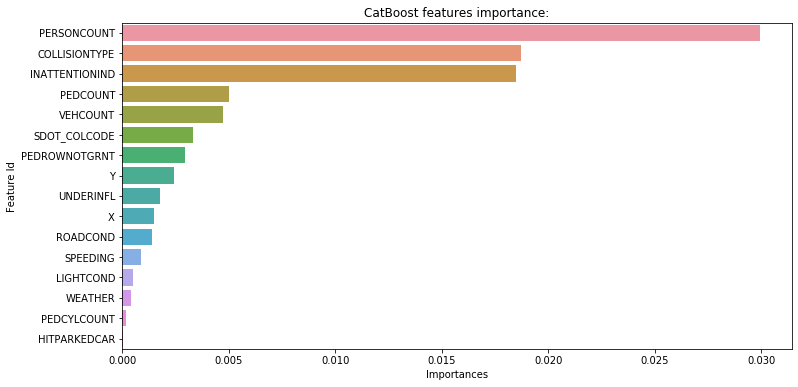

In [204]:
# feature importance
df_catboost_feature_importance = model.get_feature_importance(data=train_pool,
                                 type='LossFunctionChange',
                                 prettified=True,
                                 thread_count=-1,verbose=False)

plt.figure(figsize=(12, 6));
sns.barplot(x="Importances", y="Feature Id", data=df_catboost_feature_importance);
plt.title('CatBoost features importance:');

In [205]:
explainer = shap.TreeExplainer(model) # insert your model
shap_values = explainer.shap_values(train_pool) # insert your train Pool object

# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[:100,:], X_train.iloc[:100,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


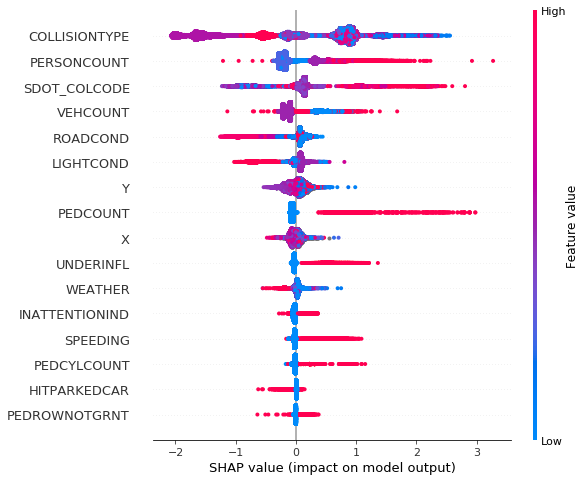

In [206]:
shap.summary_plot(shap_values, X_train)